<a href="https://colab.research.google.com/github/ioahKwon/storm-analysis-zcalib/blob/main/IOAH_dao3d_zcalib_ver_202105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ◈ **This ipynb file was made by IOAH, SNU GSCST.** ◈

Version 1.0.0 (2021. 05. 06.)

### Z Calibration Curves for 3D-DAOSTORM (and sCMOS).

In this example we are trying to determine the coefficients $w_o,c,d,A,B,C,D$ in this equation:

\begin{equation*}
W_{x,y} = w_o \sqrt{1 + \left(\frac{z-c}{d}\right)^2 + A\left(\frac{z-c}{d}\right)^3 + B\left(\frac{z-c}{d}\right)^4 + C\left(\frac{z-c}{d}\right)^5 + D\left(\frac{z-c}{d}\right)^6}
\end{equation*}

This is a modified form of a typical microscope defocusing curve. $W_x$, $W_y$ are the widths of the localization as measured by 3D-DAOSTORM and $z$ is the localization $z$ offset in $um$.

See also [Huang et al, Science, 2008](http://dx.doi.org/10.1126/science.1153529).


## **1) Calibration : Configuration**


### ① Setting 1 : Getting Data and Storm Analysis from google drive & github.

In [ ]:
# FIXME: This approach is very brittle. There would seem to be several
#        solutions, none of which I was able to figure out how to actually
#        implement.
#
#        1. Query for the name and directory of the installed .egg file.
#        2. Don't install project, just add it's location to Python's
#           module search path.
#
import sys

# Test to see if we need to install storm-analysis or if we already did this.
try:
  import storm_analysis
  
except ModuleNotFoundError:

  # Install SCONS and FFTW3 C library.
  !apt install scons
  !apt install libfftw3-dev

  # Get latest version of storm-analysis.
  # original : !git clone https://github.com/ZhuangLab/storm-analysis.git

  # GIT Hub : https://github.com/ioahKwon/
  # !git clone https://github.com/ioahKwon/storm-analysis-IOAH.git # IOAH Version (2021.05.12.)
  !git clone https://github.com/KimLab-SNU/storm-analysis-kimlab.git # IOAH Version (last updated: 2021. 05. 12.)

  # Change to directory and compile.
  %cd storm-analysis-kimlab
  !scons

  # Install storm-analysis project.
  !{sys.executable} setup.py install
  
  # Manually add the installed storm-analysis project to the path.
  sys.path.append('/usr/local/lib/python3.6/dist-packages/storm_analysis-2.1-py3.6.egg')

  # Install dependencies.
  !{sys.executable} -m pip install tifffile

  # Return to parent directory.
  %cd ..

# These are for diagnostics.
!pwd
!ls

/content
calibration.hdf5  sample_data		 test_measure.xml  wobble.txt
calibration.txt   storm-analysis-kimlab  val_measure.hdf5
calibration.xml   test_measure.hdf5	 val_measure.txt
gdrive		  test_measure.txt	 val_measure.xml


In [ ]:
# Warn user to restart kernel in order for storm-analysis to load properly. 
# The problem is that running Python might not be able to find the installed 
# library if isn't where we expected it to be.
#
try:
  import storm_analysis
  
except ModuleNotFoundError:
  print("Storm-analysis not found!")
  print("Restart Python kernel before continuing!")
  
else:
  for elt in sys.path:
    if "storm" in elt:
      print(elt)

/usr/local/lib/python3.7/dist-packages/storm_analysis-2.2-py3.7.egg


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Data path
data_path = "/content/gdrive/My Drive/data/20210326"

# Load sample z_offsets.txt file. In this example every frame is valid.
import numpy
import os
import tifffile as tiff

# Z offsets profile
######z_offsets = numpy.loadtxt("z_offsets.txt")
address_z_offsets = os.path.join(data_path, "z_offsets.txt")
print("Location of z_offsets : ", address_z_offsets)
z_offsets = numpy.loadtxt(address_z_offsets)
######print(z_offsets)

# Bead Locations
address_bead_locs = os.path.join(data_path, "bead_locs.txt")
print("Location of bead_locs : ", address_bead_locs)

bead_locs = numpy.loadtxt(address_bead_locs)
print(bead_locs)


# Tiff file
print("\n")
tif_file = os.path.join(data_path,"obSTORM_3DPSF_RedBead175nmDia_f200Cyl_z1_m1p8um_30nm_1p8um_1_combined.tif" )
print("tif_file : ",tif_file)
image = tiff.imread(tif_file)
print(image)

Location of z_offsets :  /content/gdrive/My Drive/data/20210326/z_offsets.txt
Location of bead_locs :  /content/gdrive/My Drive/data/20210326/bead_locs.txt
[[ 23.  24.]
 [ 68.  24.]
 [113.  24.]
 [158.  24.]]


tif_file :  /content/gdrive/My Drive/data/20210326/obSTORM_3DPSF_RedBead175nmDia_f200Cyl_z1_m1p8um_30nm_1p8um_1_combined.tif
[[[4367 4429 4336 ... 4464 4421 4399]
  [4360 4332 4314 ... 4330 4379 4481]
  [4307 4378 4313 ... 4364 4406 4370]
  ...
  [4247 4313 4285 ... 5148 5281 5463]
  [4360 4302 4283 ... 5597 5083 5410]
  [4237 4231 4233 ... 5614 5315 5148]]

 [[4307 4445 4365 ... 4512 4596 4596]
  [4372 4283 4342 ... 4355 4391 4398]
  [4370 4323 4265 ... 4393 4399 4348]
  ...
  [4194 4256 4333 ... 5228 5281 5023]
  [4301 4286 4264 ... 5403 5545 5414]
  [4299 4464 4237 ... 5241 5300 5194]]

 [[4344 4498 4237 ... 4403 4628 4448]
  [4263 4242 4364 ... 4442 4382 4458]
  [4423 4399 4204 ... 4457 4426 4463]
  ...
  [4303 4309 4291 ... 5386 5344 5376]
  [4228 4297 4311 ... 5436 5470 53

### ② Setting 2 : Parameter Settings.

Set parameters for 3D-DAOSTORM analysis. Note the analysis is done using the `3d` PSF model, a Gaussian with independent widths in X/Y.

In [ ]:
import storm_analysis.sa_library.parameters as params

# Load the parameters
params = params.ParametersDAO()

# Analysis parameters

###########################
###  Essential Parameter ##
###########################
pixel_size = 144.5                                                # CCD pixel size (in nm)
max_z = 2.0
min_z = -2.0
z_step = 0.001
sigma = 1.5
###########################


params.changeAttr("pixel_size", pixel_size)                       # CCD pixel size (in nm)
params.changeAttr("max_frame", -1)                                # The frame to stop analysis on, -1 = analyze to the end of the film.
params.changeAttr("start_frame", -1)                              # The frame to start analysis on, -1 = start at the beginning of the film
params.changeAttr("max_z", max_z)                                  # Maximum z value for z fitting, specified in um. ( z_range )
params.changeAttr("min_z", min_z)                                  # Minimum z value for z fitting, specified in um. ( z_range )
params.changeAttr('verbosity', 1)                                 # Frequency in frames at which to provide feedback. The default is every frame (verbosity = 1). This should be an integer >= 1.
params.changeAttr('static_background_estimate', 0)                # If this is set, and set to a number greater than 0, then the analysis will estimate the background by using the average over this number of frames.
                                                                    # If this is not set, or set to 0, the background is estimated separately for each frame.
# Tracking parameters
params.changeAttr("descriptor", 1)                                # Tracking parameter, frame descriptor string :
                                                                    # 0 - activation frame
                                                                    # 1 - non-specific frame
                                                                    # 2 - channel1 frame
                                                                    # 3 - channel2 frame
                                                                    # 4 - etc..

params.changeAttr("radius", 0.5)                                  # Radius for matching peaks from frame to frame. Localizations that are closer than
                                                                    # this value (in pixels) in adjacent frames (ignoring activation frames) are assumed
                                                                    # to come from the same emitter and are averaged together to create a (hopefully) 
                                                                    # more accurately localized emitter. If this is zero then no matching will be done
                                                                    # if it is 0, don't do tracking.
                                                                  # Maximum distance for an object to be in a track in pixels. 

# Drift Correction parameters
params.changeAttr("d_scale", 2)                                   # if your data is 256x256 pixels then the drift-correction will create 512x512 sub-STORM 
                                                                    # images (for d_scale = 2) and then attempt to correlate these images to each other to calculate the drift.
                                                                    # 2 is usually a good choice.
params.changeAttr("drift_correction", 0)                          # Do drift correction, 0 ='No'
params.changeAttr("z_correction", 0)                              # Do z drift correction, 0 = 'No'
params.changeAttr("frame_step", 100)                              # Number of frames in each (drift correction) sub-STORM image # 500


# Fitting parameters

params.changeAttr("background_sigma", 8.0)                        # Background filter sigma, this is the sigma of a 2D gaussian to convolve the data in order to estimate the background.

params.changeAttr("fftw_estimate", 0)                             # FFTW should estimate the best FFT plan instead of measuring which is best. This 
                                                                    # can help speed the analysis of short movies that are very large in XY. 0 = (default) 
                                                                    # FFTW will measure the best FFT plan. 1 = FFTW will estimate the best FFT plan.

params.changeAttr("fit_error_model", "MLE")                       # Specify which fitting error model to use. # Other Options : ALS(Anscombe Least Squares), LS(Least Squares), DWLS(Data Weighted Least Squares), FWLS(Fit Weighted Least Squares)
params.changeAttr("find_max_radius", 10,  node_type='int')         # To be a peak it must be the maximum value within this radius (in pixels).
                                                                    # Using a large find max radius -> reduces peak splitting.
params.changeAttr("iterations", 20)                               # Maximum number of iterations for new peak finding.
params.changeAttr("sigma", sigma)                                  # This is the estimated sigma of the PSF in pixels.
                                                                    # It is used in most of the analysis approaches as a measure of the peak to peak distance at which peak fits do not substantially effect each other.
                                                                    # In most of the analysis approaches, if two peaks are closer than
                                                                    #	this distance then the dimmer one will be discarded.
params.changeAttr('sigma_range', [0.5*sigma, 5.0*sigma])         # A two element array that specifies the minimum and maximum sigma values to allow when fitting for the peak width. 
                                                                    # If this is not specified the default is [0.5 * sigma, 5.0 * sigma].


params.changeAttr("threshold", 10 )                                # Threshold for a maximum to considered a peak.
                                                                    # This is the threshold for peak finding in units of signal to background. A
                                                                    # value of 3 for example corresponds to only selecting peaks with an (estimated)
                                                                    # signal to background ratio of 3.
                                                                    # You probably want a value of at least 5.

# Parameters that are common to 3D-DAOSTORM and sCMOS
params.changeAttr("cutoff", 5)                                    # Max allowed distance from the wx/wy versus Z curve, units unclear.
params.changeAttr("do_zfit", 0)                                   # Do z fitting (or not), only relevant for "3d" fitting (see "model" parameter).
params.changeAttr("foreground_sigma", 1.5)                        # Foreground filter sigma, this is the sigma of a 2D gaussian to convolve the data with
                                                                    # prior to peak identification. When your data has a low SNR this can help for peak
                                                                    # finding. For optimal sensitivity it should be the same as the expected sigma for your peaks.
                                                                    # If you set it to zero (or comment it out) then this will not be performed, which can make the analysis faster.
params.changeAttr("model", "3d")                                  # Options: 2dfixed, 2d, 3d, Z
                                                                    # 2dfixed - fixed sigma 2d gaussian fitting.
                                                                    # 2d - variable sigma 2d gaussian fitting.
                                                                    # 3d - x, y sigma are independently variable, z will be fit after peak fitting.
                                                                    # Z - x, y sigma depend on z, z is fit as part of peak fitting.
params.changeAttr("roi_size", 28)                                 # This is the size of the fitting ROI in pixels. If it is not specified than the value
                                                                    # will be calculated based on the sigma parameter value and the fitting model type
params.changeAttr("z_value", 0)                                   # The starting z value for fitting. If this is not specified it defaults to 0.0.
params.changeAttr("z_step", z_step)                                # Step size of Z search in microns.
                                                                    # this is not specified it defaults to 1 nanometer. Units are microns.
# Saving Options
params.changeAttr('convert_to', ".txt")                           # Specify what, if any, formats to convert the output HDF5 file into upon completion of the analysis.
                                                                    # Options are .bin and .txt.
                                                                    # Use a comma separated list if you want both. i.e. ".bin, .txt".

# Wx/Wy vs Z parameters. Units are nanometers or dimensionless                                                                    
params.changeAttr("wxA", 0)
params.changeAttr("wxB", 0)
params.changeAttr("wxC", 0)
params.changeAttr("wxD", 0)
params.changeAttr("wx_c", 0)
params.changeAttr("wx_d", 0)
params.changeAttr("wx_wo", 0)
params.changeAttr("wyA", 0)
params.changeAttr("wyB", 0)
params.changeAttr("wyC", 0)
params.changeAttr("wyD", 0)
params.changeAttr("wy_c", 0.0)
params.changeAttr("wy_d", 0)
params.changeAttr("wy_wo", 0)


# Parameters that are specific to 3D-DAOSTORM analysis
params.changeAttr("camera_gain", 9.20)                            # 31.3/3.4 # Conversion factor to go from camera ADU to photo-electrons(ADU/photo-electron). Units are ADU/e-, so the camera ADU values will be divided by this number to convert to photo-electrons.
#params.changeAttr("camera_offset", 31.3)                          # 4205 This is what the camera reads with the shutter closed. Offset is in units of ADU.
params.changeAttr("camera_offset", 0)

# Help : Other parameters or Analysis Settings
#print(params.helpAttr('sigma')) # for example. helpAttr(name)
#print('\n')

params.prettyPrint()

aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 0
convert_to (string) - .txt
cutoff (float) - 5
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 0
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 20
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 2.0
min_z (float) - -2.0
model (string) - 3d
no_fitting (int) - None
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.5
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 10
verbosity (int) - 1
wxA (float) - 0
wxB (float) - 0
wxC (float) - 0
wxD (float) - 0
wx_c (float) - 0
wx_d (float) - 0
wx_wo (float) - 0
wyA (float) - 0
wyB (float) - 0
wyC (float) - 0
wyD (float) - 0
wy_c (float) - 0.0
wy_d (float)

In [ ]:
# Set for a single iteration, we don't want multiple iterations of peak finding
# as this could cause stretched peaks to get split in half.
params.changeAttr("iterations", 1)

# Use a large find max radius. This also reduces peak splitting.
params.changeAttr("find_max_radius", 10)

# Use a higher threshold so that we don't get the dimmer localizations.
params.changeAttr("threshold", 18)

# Don't do tracking or drift correction.
params.changeAttr("radius", 0.0)
params.changeAttr("drift_correction", 0)

# Save the changed parameters.
params.toXMLFile("calibration.xml")

params.prettyPrint()


aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 0
convert_to (string) - .txt
cutoff (float) - 5
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 0
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 1
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 2.0
min_z (float) - -2.0
model (string) - 3d
no_fitting (int) - None
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.0
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 18
verbosity (int) - 1
wxA (float) - 0
wxB (float) - 0
wxC (float) - 0
wxD (float) - 0
wx_c (float) - 0
wx_d (float) - 0
wx_wo (float) - 0
wyA (float) - 0
wyB (float) - 0
wyC (float) - 0
wyD (float) - 0
wy_c (float) - 0.0
wy_d (float) 

## **2) Calibration : Analyze**

### ① Analyzing Process

Analyze the calibration movie with 3D-DAOSTORM

In [ ]:
import os
import storm_analysis.daostorm_3d.mufit_analysis as mfit

if os.path.exists("calibration.hdf5"):
    os.remove("calibration.hdf5")
    
mfit.analyze(tif_file, "calibration.hdf5", "calibration.xml")



version 2020.07.01

Peak finding
Frame : (Current Frame) (Added Peaks) (Total Peaks)
Frame: 0 4 4
Frame: 1 4 8
Frame: 2 4 12
Frame: 3 4 16
Frame: 4 4 20
Frame: 5 4 24
Frame: 6 4 28
Frame: 7 4 32
Frame: 8 4 36
Frame: 9 4 40
Frame: 10 4 44
Frame: 11 4 48
Frame: 12 4 52
Frame: 13 4 56
Frame: 14 4 60
Frame: 15 4 64
Frame: 16 4 68
Frame: 17 4 72
Frame: 18 4 76
Frame: 19 4 80
Frame: 20 4 84
Frame: 21 4 88
Frame: 22 4 92
Frame: 23 4 96
Frame: 24 4 100
Frame: 25 4 104
Frame: 26 4 108
Frame: 27 4 112
Frame: 28 4 116
Frame: 29 4 120
Frame: 30 4 124
Frame: 31 4 128
Frame: 32 4 132
Frame: 33 4 136
Frame: 34 4 140
Frame: 35 4 144
Frame: 36 4 148
Frame: 37 4 152
Frame: 38 4 156
Frame: 39 4 160
Frame: 40 4 164
Frame: 41 4 168
Frame: 42 4 172
Frame: 43 4 176
Frame: 44 4 180
Frame: 45 4 184
Frame: 46 4 188
Frame: 47 4 192
Frame: 48 4 196
Frame: 49 4 200
Frame: 50 4 204
Frame: 51 4 208
Frame: 52 4 212
Frame: 53 4 216
Frame: 54 4 220
Frame: 55 4 224
Frame: 56 4 228
Frame: 57 4 232
Frame: 58 4 236
Frame:

Check results with overlay images.

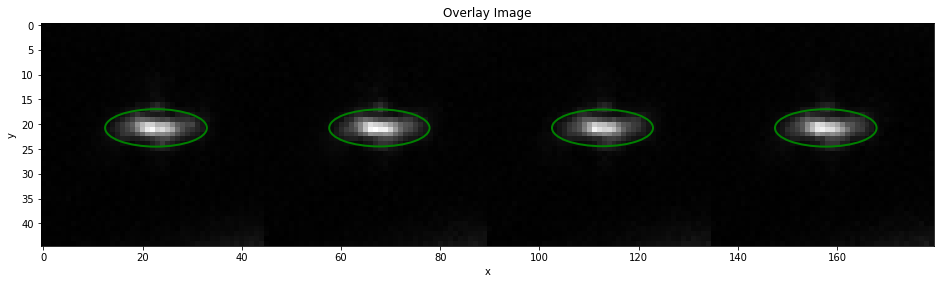

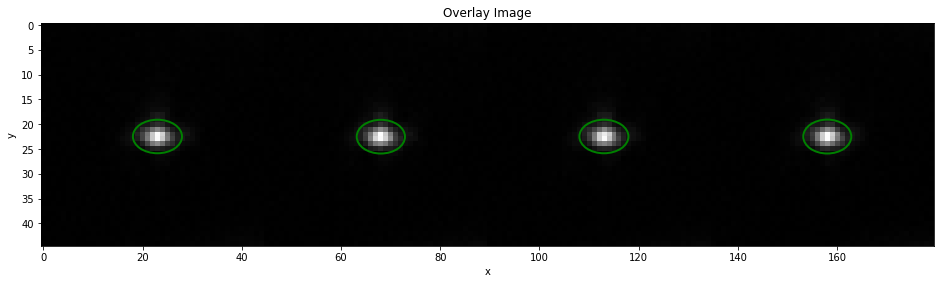

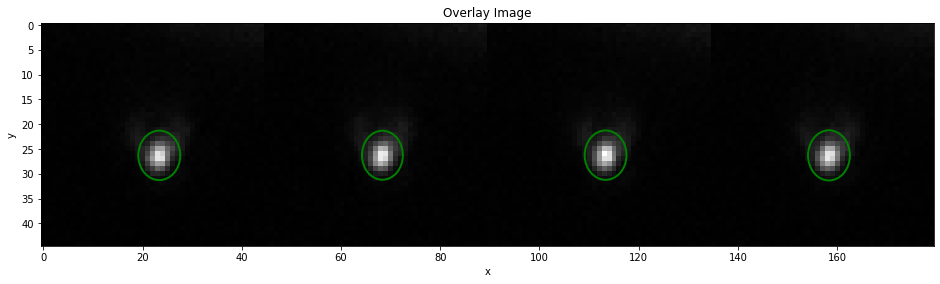

In [ ]:
# Overlay image at z near zero.
import storm_analysis.jupyter_examples.overlay_image as overlay_image

overlay_image.overlayImage(tif_file, "calibration.hdf5", 10, sx = 16, sy = 16)
overlay_image.overlayImage(tif_file, "calibration.hdf5", 40, sx = 16, sy = 16)
overlay_image.overlayImage(tif_file, "calibration.hdf5", 90, sx = 16, sy = 16)

Creating an image from the analysis

Tracks not found, using localizations.
.


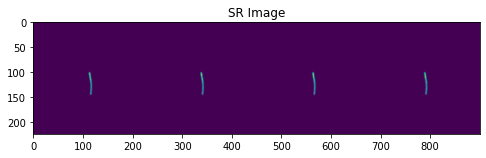

In [ ]:
import matplotlib
import matplotlib.pyplot as pyplot
import storm_analysis.sa_utilities.hdf5_to_image as h5_image

#     Create a grayscale image from a HDF5 format localizations file. This will use
#    the tracks if available, otherwise it will use the localizations.


"""
    Create a grayscale image from a HDF5 format localizations file. This will use
    the tracks if available, otherwise it will use the localizations.

    h5_name - The name of the HDF5 file.
    category - Filter for localizations of this category. The default is all categories.
    offsets - List containing [X,Y] offset of the image origin.  The default is no offset.
    scale - The 'zoom' level of the output image, i.e. if the original STORM movie was
            256x256 and scale = 2 then the output image will be 512x512.
    sigma - The sigma to use when rendering gaussians (pixels). If this is None then
            the image will be a histogram.
"""

sr_im = h5_image.render2DImage("calibration.hdf5", scale = 5, sigma = 1) # # This sigma is not same value with above sigma. It has other meaning.

fig = pyplot.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
ax.imshow(sr_im)
ax.set_title("SR Image")

pyplot.show()

### (Optional) Create beads text file for Wobble Correction

In [ ]:
def hdf5ToWobbleText(hdf5_name, text_name, x_pix_to_nm, y_pix_to_nm):
    import storm_analysis.sa_library.sa_h5py as saH5Py
    smlc_file_fp = open(text_name, "w")
    smlc_file_fp.write("index, frame, xnano, ynano, znano, intensity\n")

    print("Saving Localizations")
    count = 0
    with saH5Py.SAH5Py(hdf5_name) as h5:
        for fnum, locs in h5.localizationsIterator(fields = ["x", "y", "sum"]):
                 
            for i in range(locs["x"].size):
                count += 1
                xp = locs["x"][i]*x_pix_to_nm
                yp = locs["y"][i]*y_pix_to_nm
                zp = 0.0
                intensity = locs["sum"][i]
                    
                smlc_file_fp.write("{0:d}, {1:d}, {2:.3f}, {3:.3f}, {4:.3f}, {5:.3f}\n".format(count, fnum, xp, yp, zp, intensity))

    print()
    print("Saved", count, "localizations.")
    smlc_file_fp.close()

In [ ]:
hdf5ToWobbleText("calibration.hdf5", "wobble.txt", 144.5, 144.5) # x_pix_to_nm, y_pix_to_nm

Saving Localizations

Saved 484 localizations.


### ② Plotting the calibration result

Plot Wx / Wy versus Z curves.

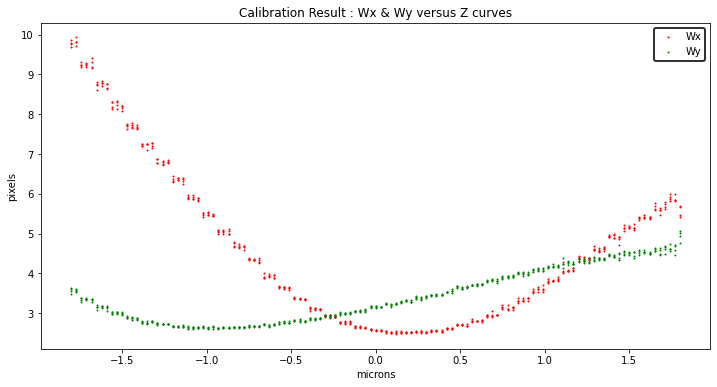

In [ ]:
import matplotlib
import matplotlib.pyplot as pyplot

# Change default figure size.
matplotlib.rcParams['figure.figsize'] = (12,6)

import storm_analysis.daostorm_3d.z_calibration as z_cal

[wx, wy, z, pixel_size] = z_cal.loadWxWyZData("calibration.hdf5", address_z_offsets)

p1 = pyplot.scatter(z, wx, color = 'r', label = 'Wx', s=1) # Curves1 (z vs wx)
p2 = pyplot.scatter(z, wy, color = 'g', label = 'Wy', s=1) # Curves2 (z vs wy)
legend = pyplot.legend(handles = [p1, p2], loc=1)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
pyplot.xlabel("microns")
pyplot.ylabel("pixels")
pyplot.title("Calibration Result : Wx & Wy versus Z curves")
pyplot.show()

Fitting (round 1).
[2.2397124806668436, 0.3070383061963664, 0.5495018096760297]
Fitting (round 2).
[2.4801051133426175, 0.197089385343809, 0.7577135190449917, -0.056405708354296334, 0.18629460188115746, -0.03188737068566762, -0.019749065971637458]
Removing outliers.
Fitting (round 3).


/usr/local/lib/python3.7/dist-packages/storm_analysis-2.2-py3.7.egg/storm_analysis/daostorm_3d/z_calibration.py:396: RuntimeWarning: invalid value encountered in sqrt
  return wo*numpy.sqrt(1.0 + numpy.power(X,2) + A * numpy.power(X,3) + B * numpy.power(X,4) + C * numpy.power(X,5) + D * numpy.power(X,6))


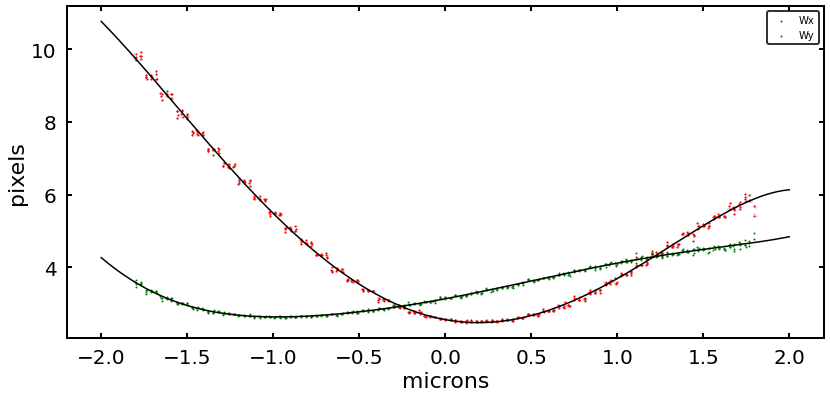

<?xml version="1.0" encoding="ISO-8859-1"?>
<xml>
   <wx_wo>358.270</wx_wo>
   <wx_c>193.353</wx_c>
   <wx_d>754.752</wx_d>
   <wxA>-0.075</wxA>
   <wxB>0.177</wxB>
   <wxC>-0.027</wxC>
   <wxD>-0.018</wxD>
   <wy_wo>381.017</wy_wo>
   <wy_c>-976.984</wy_c>
   <wy_d>1291.441</wy_d>
   <wyA>-0.832</wyA>
   <wyB>0.973</wyB>
   <wyC>-0.542</wyC>
   <wyD>0.100</wyD>
</xml>



In [ ]:
###
### The function z_cal.calibrate() will perform all of these steps at once.
###

fit_order = 4
outliers = 5.0 # Sigma to be considered an outlier.

###################################################
#############  Parameter Discription ##############
###################################################

##     wx_params - Parameters for wx versus z fit.
##     wy_params - Parameters for wy versus z fit.
##     z - Numpy array with z values in microns.
##     n_additional - The number of additional fitting parameters to use,
##                    these are 'A,B,C,D'.
##     z_params - (Optional) 3 element list containing an initial guess
##                for the z fitting parameters.

# Mark all locations outside of the specified z range as category 9.


###################################################
###################################################

# Initial guess, this is optional, but might be necessary if your setup is
# significantly different from what storm-analysis expects.

# It can also help to boot-strap to higher fitting orders.

p_start = [3.2,0.19,0.3]
###################################################
###################################################

# Fit curves
print("Fitting (round 1).")
[wx_params, wy_params] = z_cal.fitDefocusingCurves(wx, wy, z, n_additional = 0, z_params = p_start)
print(wx_params)
p_start = wx_params[:3]

# Fit curves.
print("Fitting (round 2).")
[wx_params, wy_params] = z_cal.fitDefocusingCurves(wx, wy, z, n_additional = fit_order, z_params = p_start)
print(wx_params)
p_start = wx_params[:3]

# Remove outliers.
  # This removes all wx, wy that are more than threshold sigma from the fit curve.
print("Removing outliers.")
[t_wx, t_wy, t_z] = z_cal.removeOutliers(wx, wy, z, wx_params, wy_params, outliers)

# Redo fit.
print("Fitting (round 3).")
[wx_params, wy_params] = z_cal.fitDefocusingCurves(t_wx, t_wy, t_z, n_additional = fit_order, z_params = p_start)

# Plot fit.
z_cal.plotFit(wx, wy, z, t_wx, t_wy, t_z, wx_params, wy_params, z_min = min_z, z_max = max_z, z_step = z_step)

# This prints the parameter with the scale expected by 3D-DAOSTORM in the analysis XML file.
z_cal.prettyPrint(wx_params, wy_params, pixel_size = pixel_size)

### ③ Saving New Parameters : 
Create a parameters file with these calibration values.



In [ ]:
import storm_analysis.sa_library.parameters as params

# Load the parameters.
new_params = params.ParametersDAO().initFromFile("calibration.xml")

# Update calibration parameters.
z_cal.setWxWyParams(new_params, wx_params, wy_params, pixel_size)

# Do z fitting.
new_params.changeAttr("do_zfit", 1)

# Set maximum allowed distance in wx, wy space that a point can be from the 
# calibration curve.
# Max allowed distance from the wx/wy versus Z curve, units unclear.

new_params.changeAttr("cutoff", 5.0)

# Use a higher threshold as the Gaussian PSF is not a good match for our PSF model, so
# we'll get spurious peak splitting if it is too low.
new_params.changeAttr("threshold", 18)

# Don't do tracking or drift correction as this movie is the same as the calibration
# movie, every frame has a different z value.
new_params.changeAttr("radius", 0.0)
new_params.changeAttr("drift_correction", 0)
new_params.changeAttr("camera_offset",0) #4139

new_params.prettyPrint()

# Save the changed parameters.
new_params.toXMLFile("measure.xml")

aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 0
convert_to (string) - .txt
cutoff (float) - 5.0
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 1
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 1
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 2.0
min_z (float) - -2.0
model (string) - 3d
no_fitting (int) - None
parameters_file (parameters_filename) - calibration.xml
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.0
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 18
verbosity (int) - 1
wxA (float) - -0.07505924964083177
wxB (float) - 0.17702293126080298
wxC (float) - -0.026606965489447573
wxD (float) - -0.01755184393945545
wx_c (float) -

## **3) Calibration Validation : Analyze**


### ① Analyze calibration movie with the above z-calibration parameters.

In [ ]:
import storm_analysis.sa_library.parameters as params

# Load the parameters.
new_params = params.ParametersDAO().initFromFile("measure.xml")
new_params.prettyPrint()

# Save the changed parameters.
new_params.toXMLFile("val_measure.xml")

aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 0.0
convert_to (string) - .txt
cutoff (float) - 5.0
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 1
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 1
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 2.0
min_z (float) - -2.0
model (string) - 3d
no_fitting (int) - None
parameters_file (parameters_filename) - calibration.xml
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.0
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 18.0
verbosity (int) - 1
wxA (float) - -0.07505924964083177
wxB (float) - 0.17702293126080298
wxC (float) - -0.026606965489447573
wxD (float) - -0.01755184393945545
wx_c (floa

In [ ]:
val_file = tif_file

In [ ]:
if os.path.exists("val_measure.hdf5"):
    os.remove("val_measure.hdf5")
    
%time mfit.analyze(val_file, "val_measure.hdf5", "val_measure.xml")


version 2020.07.01

Peak finding
Frame : (Current Frame) (Added Peaks) (Total Peaks)
Frame: 0 4 4
Frame: 1 4 8
Frame: 2 4 12
Frame: 3 4 16
Frame: 4 4 20
Frame: 5 4 24
Frame: 6 4 28
Frame: 7 4 32
Frame: 8 4 36
Frame: 9 4 40
Frame: 10 4 44
Frame: 11 4 48
Frame: 12 4 52
Frame: 13 4 56
Frame: 14 4 60
Frame: 15 4 64
Frame: 16 4 68
Frame: 17 4 72
Frame: 18 4 76
Frame: 19 4 80
Frame: 20 4 84
Frame: 21 4 88
Frame: 22 4 92
Frame: 23 4 96
Frame: 24 4 100
Frame: 25 4 104
Frame: 26 4 108
Frame: 27 4 112
Frame: 28 4 116
Frame: 29 4 120
Frame: 30 4 124
Frame: 31 4 128
Frame: 32 4 132
Frame: 33 4 136
Frame: 34 4 140
Frame: 35 4 144
Frame: 36 4 148
Frame: 37 4 152
Frame: 38 4 156
Frame: 39 4 160
Frame: 40 4 164
Frame: 41 4 168
Frame: 42 4 172
Frame: 43 4 176
Frame: 44 4 180
Frame: 45 4 184
Frame: 46 4 188
Frame: 47 4 192
Frame: 48 4 196
Frame: 49 4 200
Frame: 50 4 204
Frame: 51 4 208
Frame: 52 4 212
Frame: 53 4 216
Frame: 54 4 220
Frame: 55 4 224
Frame: 56 4 228
Frame: 57 4 232
Frame: 58 4 236
Frame:

### ② Plotting the validation result of calibration data

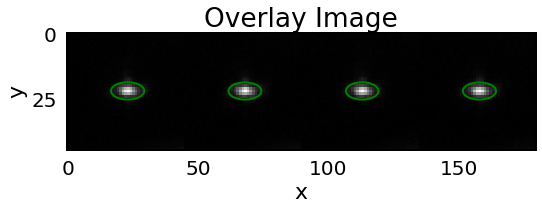

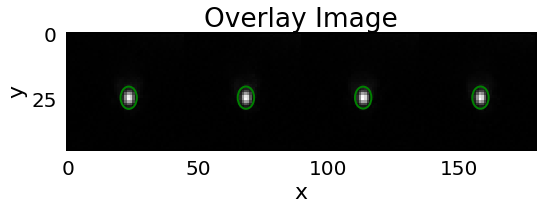

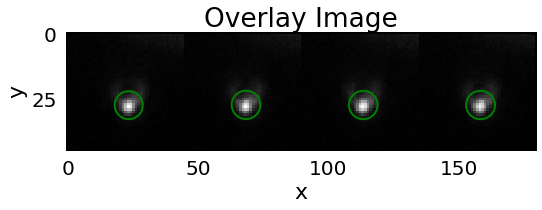

In [ ]:
overlay_image.overlayImage(val_file, "val_measure.hdf5", 30)
overlay_image.overlayImage(val_file, "val_measure.hdf5", 70)
overlay_image.overlayImage(val_file, "val_measure.hdf5", 100)

Total Localization :  484
Total length wx_good :  484
Total length wy_good :  484




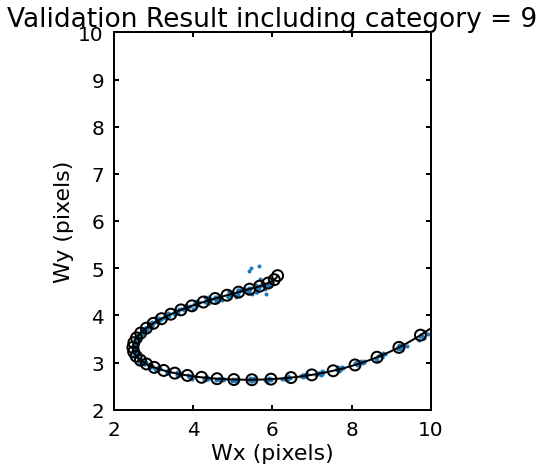

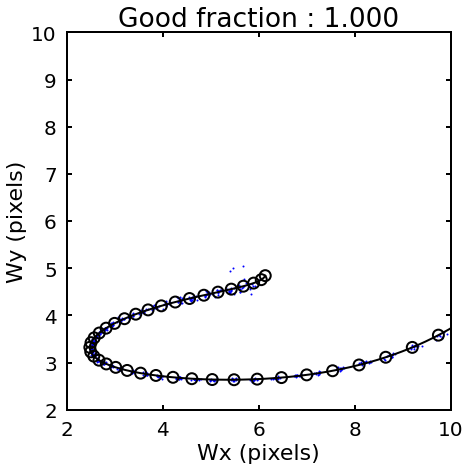

In [ ]:
import storm_analysis.sa_library.sa_h5py as saH5Py
import numpy

locs = saH5Py.loadLocalizations("val_measure.hdf5")

mask = (locs["category"] != 9) # Mark out of z range localizations and tracks as category 9.
wx_good = 2.0*locs["xsigma"][mask]
wy_good = 2.0*locs["ysigma"][mask]

mask = (locs["category"] == 9) # Mark out of z range localizations and tracks as category 9.
wx_bad = 2.0*locs["xsigma"][mask]
wy_bad = 2.0*locs["ysigma"][mask]

print("Total Localization : ", len(locs["z"]))
print("Total length wx_good : ", len(wx_good))
print("Total length wy_good : ", len(wy_good))
print("\n")

# Load Z calibration parameters.
m_params = params.ParametersDAO().initFromFile("val_measure.xml")

[wx_params, wy_params] = m_params.getWidthParams()
[min_z, max_z] = m_params.getZRange()

# Z range is in microns, want nanometers.
min_z = min_z * 1.0e+3
max_z = max_z * 1.0e+3

# Calculate fit z curve at high resolution

fz_wx_1 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size
fz_wy_1 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size

# Calculate fit z curve at 100nm resolution.

fz_wx_2 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size
fz_wy_2 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size

# Make figure.
fig = pyplot.figure(figsize = (7,7))
pyplot.scatter(wx_good, wy_good, marker = ".")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.title("Validation Result including category = 9".format(wx_good.size/mask.size))
pyplot.show()

# classified by categories ( Blue -> category != 9, Red -> category = 9)
pyplot.figure(figsize = (7,7))
pyplot.scatter(wx_good, wy_good, s = 1, color = "blue")
pyplot.scatter(wx_bad, wy_bad, s = 1, color = "red")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.title("Good fraction : {0:.3f}".format(wx_good.size/mask.size))
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.show()

## **3) Test : Analyze**


### ① Analyze test movie with the above z-calibration parameters.

In [ ]:
import storm_analysis.sa_library.parameters as params

# Load the parameters.
new_params = params.ParametersDAO().initFromFile("measure.xml")

new_params.changeAttr("camera_offset", 4137) #4139

new_params.prettyPrint()

# Save the changed parameters.
new_params.toXMLFile("test_measure.xml")

aoi_radius (int) - None
background_sigma (float) - 8.0
camera_gain (float) - 9.2
camera_offset (float) - 4137
convert_to (string) - .txt
cutoff (float) - 5.0
d_scale (int) - 2
descriptor (string) - 1
do_zfit (int) - 1
drift_correction (int) - 0
fftw_estimate (int) - 0
find_max_radius (int) - 10
fit_error_model (string) - MLE
foreground_sigma (float) - 1.5
frame_step (int) - 100
iterations (int) - 1
max_frame (int) - -1
max_gap (int) - None
max_z (float) - 2.0
min_z (float) - -2.0
model (string) - 3d
no_fitting (int) - None
parameters_file (parameters_filename) - calibration.xml
peak_locations (filename) - None
pixel_size (float) - 144.5
radius (float) - 0.0
roi_size (int) - 28
sigma (float) - 1.5
sigma_range (float-array) - [0.75, 7.5]
start_frame (int) - -1
static_background_estimate (int) - 0
threshold (float) - 18.0
verbosity (int) - 1
wxA (float) - -0.07505924964083177
wxB (float) - 0.17702293126080298
wxC (float) - -0.026606965489447573
wxD (float) - -0.01755184393945545
wx_c (flo

In [ ]:
test_file = os.path.join(data_path,"STORM_video_RedBead175nmDia_18kframes_offset4132count.tif" )

In [ ]:
if os.path.exists("test_measure.hdf5"):
    os.remove("test_measure.hdf5")
    
%time mfit.analyze(test_file, "test_measure.hdf5", "test_measure.xml")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 Removing values < 1.0 in frame 15522
Frame: 15522 1 15523
 Removing values < 1.0 in frame 15523
Frame: 15523 1 15524
 Removing values < 1.0 in frame 15524
Frame: 15524 1 15525
 Removing values < 1.0 in frame 15525
Frame: 15525 1 15526
 Removing values < 1.0 in frame 15526
Frame: 15526 1 15527
 Removing values < 1.0 in frame 15527
Frame: 15527 1 15528
 Removing values < 1.0 in frame 15528
Frame: 15528 1 15529
 Removing values < 1.0 in frame 15529
Frame: 15529 1 15530
 Removing values < 1.0 in frame 15530
Frame: 15530 1 15531
 Removing values < 1.0 in frame 15531
Frame: 15531 1 15532
 Removing values < 1.0 in frame 15532
Frame: 15532 1 15533
 Removing values < 1.0 in frame 15533
Frame: 15533 1 15534
 Removing values < 1.0 in frame 15534
Frame: 15534 1 15535
 Removing values < 1.0 in frame 15535
Frame: 15535 1 15536
 Removing values < 1.0 in frame 15536
Frame: 15536 1 15537
 Removing values < 1.0 in frame 15537
Frame: 15537 1 15538
 Removing values < 1

### ② Plotting the test result

Plot Wx / Wy versus Z curves for data from the test movie.

Above Calibration curves (Black Line in calibration plotting) was used to calculate Wx / Wy versus Z values.

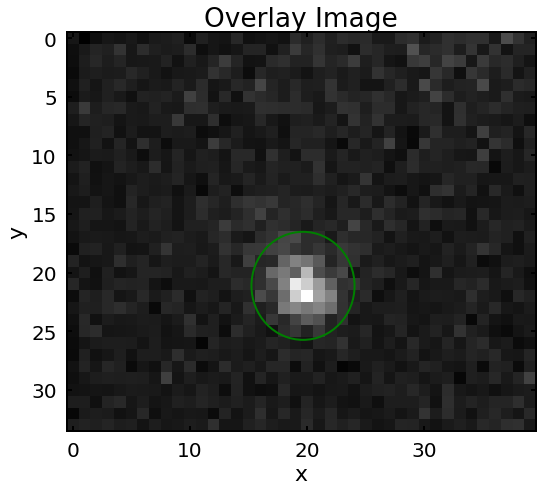

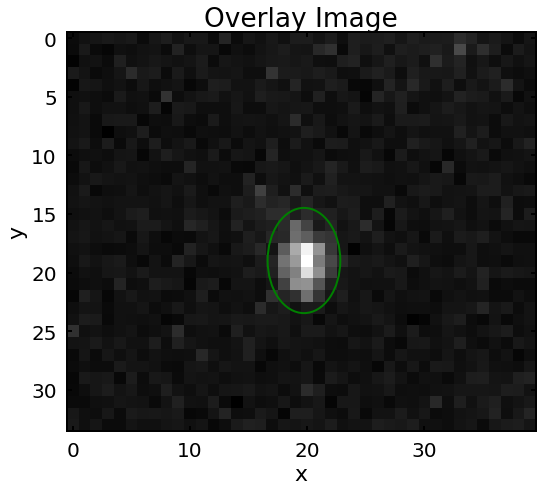

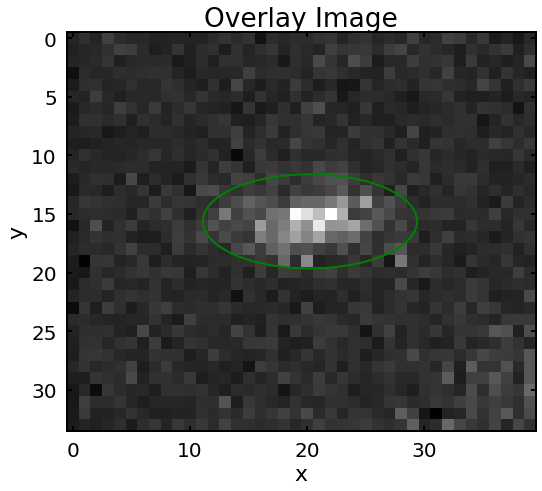

In [ ]:
overlay_image.overlayImage(test_file, "test_measure.hdf5", 3100)
overlay_image.overlayImage(test_file, "test_measure.hdf5", 7000)
overlay_image.overlayImage(test_file, "test_measure.hdf5", 15150)

## **4) Test Validation**

### ① Validation Method 1 :

Plot Wx versus Wy with the z calibration curve overlaid.

This can be useful for checking that your calibration curve matches your data.



Total Localization :  18000
Total length wx_good :  17896
Total length wy_good :  17896




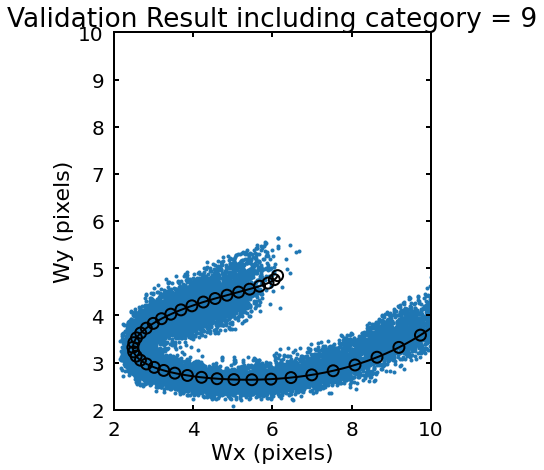

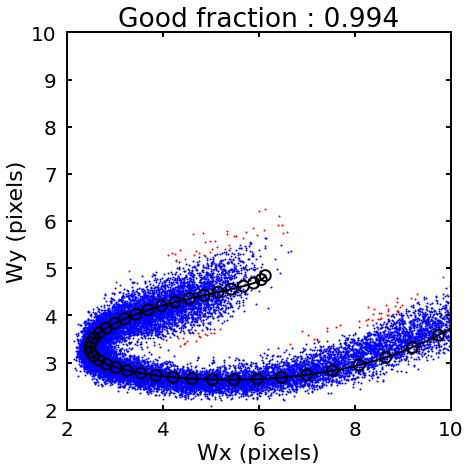

In [ ]:
import storm_analysis.sa_library.sa_h5py as saH5Py
import numpy

locs = saH5Py.loadLocalizations("test_measure.hdf5")

mask = (locs["category"] != 9) # Mark out of z range localizations and tracks as category 9.
wx_good = 2.0*locs["xsigma"][mask]
wy_good = 2.0*locs["ysigma"][mask]

mask = (locs["category"] == 9) # Mark out of z range localizations and tracks as category 9.
wx_bad = 2.0*locs["xsigma"][mask]
wy_bad = 2.0*locs["ysigma"][mask]

print("\n")
print("Total Localization : ", len(locs["z"]))
print("Total length wx_good : ", len(wx_good))
print("Total length wy_good : ", len(wy_good))
print("\n")

# Load Z calibration parameters.
m_params = params.ParametersDAO().initFromFile("test_measure.xml")

[wx_params, wy_params] = m_params.getWidthParams()
[min_z, max_z] = m_params.getZRange()

# Z range is in microns, want nanometers.
min_z = min_z * 1.0e+3
max_z = max_z * 1.0e+3

# Calculate fit z curve at high resolution

fz_wx_1 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size
fz_wy_1 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size

# Calculate fit z curve at 100nm resolution.

fz_wx_2 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size
fz_wy_2 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size

# Make figure.
fig = pyplot.figure(figsize = (7,7))
pyplot.scatter(wx_good, wy_good, marker = ".")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.title("Validation Result including category = 9".format(wx_good.size/mask.size))
pyplot.show()

# classified by categories ( Blue -> category != 9, Red -> category = 9)
pyplot.figure(figsize = (7,7))
pyplot.scatter(wx_good, wy_good, s = 1, color = "blue")
pyplot.scatter(wx_bad, wy_bad, s = 1, color = "red")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.title("Good fraction : {0:.3f}".format(wx_good.size/mask.size))
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.show()

In [ ]:
measured_z = numpy.array([])
with saH5Py.SAH5Reader("test_measure.hdf5") as h5:
    for fnum, locs in h5.localizationsIterator(fields = ["category", "z"]):
        #mask = (locs["category"] != 9)
        #z = locs["z"][mask]
        z = locs["z"]
        if z.size != 0:
          measured_z = numpy.concatenate((measured_z, z))
  
valid = numpy.ones(measured_z.size)
print(valid)
print(measured_z)

numpy.savetxt('test_measured_z.txt', numpy.transpose(numpy.vstack((valid, measured_z))), fmt='%.3f')
print("Saving succeeded.")

[1. 1. 1. ... 1. 1. 1.]
[ 2.     1.461  1.393 ... -1.876 -1.931 -1.955]
Saving succeeded.


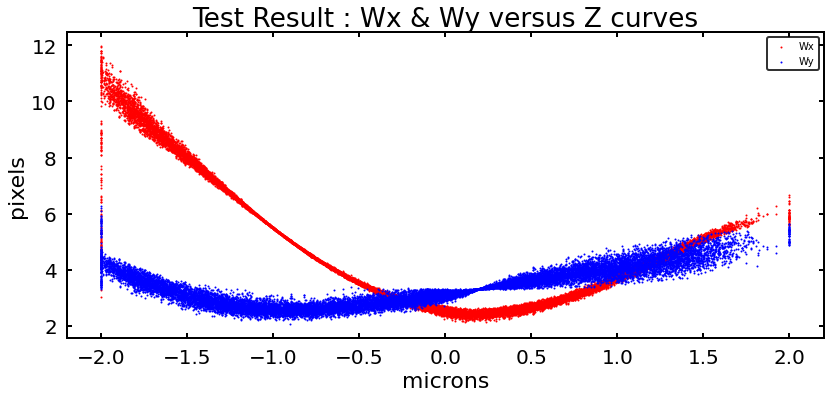

In [ ]:
[wx, wy, z, pixel_size] = z_cal.loadWxWyZData("test_measure.hdf5", "test_measured_z.txt")

p1 = pyplot.scatter(z, wx, color = 'r', label = 'Wx', s=1) # Curves1 (z vs wx)
p2 = pyplot.scatter(z, wy, color = 'b', label = 'Wy', s=1) # Curves2 (z vs wy)
legend = pyplot.legend(handles = [p1, p2], loc=1)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
pyplot.xlabel("microns")
pyplot.ylabel("pixels")
pyplot.title("Test Result : Wx & Wy versus Z curves")
pyplot.show()

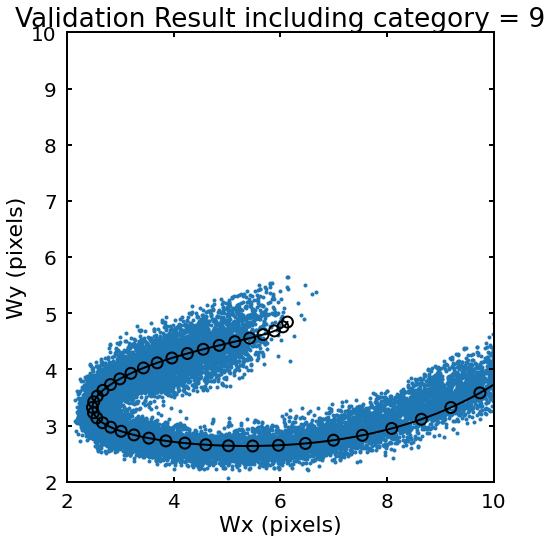

In [ ]:
pixel_size = 144.5
# Calculate fit z curve at high resolution

fz_wx_1 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size
fz_wy_1 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size

# Calculate fit z curve at 100nm resolution.

fz_wx_2 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size
fz_wy_2 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size

fig = pyplot.figure(figsize = (8,8))
pyplot.scatter(wx_good, wy_good, marker = ".")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.title("Validation Result including category = 9".format(wx_good.size/mask.size))
pyplot.show()

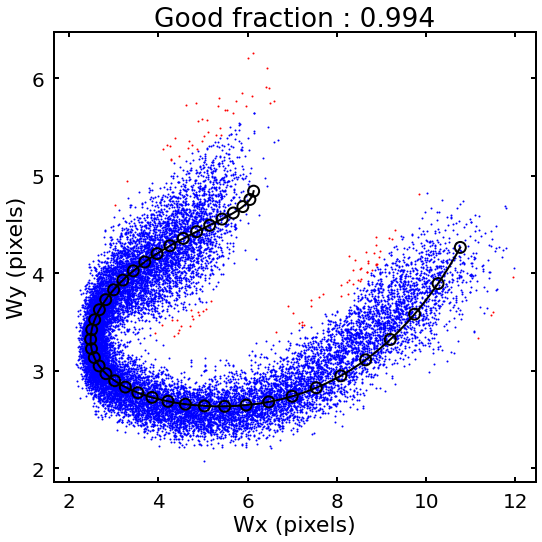

In [ ]:
# classified by categories ( Blue -> category != 9, Red -> category = 9)
pyplot.figure(figsize = (8,8))
pyplot.scatter(wx_good, wy_good, s = 1, color = "blue")
pyplot.scatter(wx_bad, wy_bad, s = 1, color = "red")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
#pyplot.xlim(2,10)
#pyplot.ylim(2,10)
pyplot.title("Good fraction : {0:.3f}".format(wx_good.size/mask.size))
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.show()

Tracks not found, using localizations.
.........


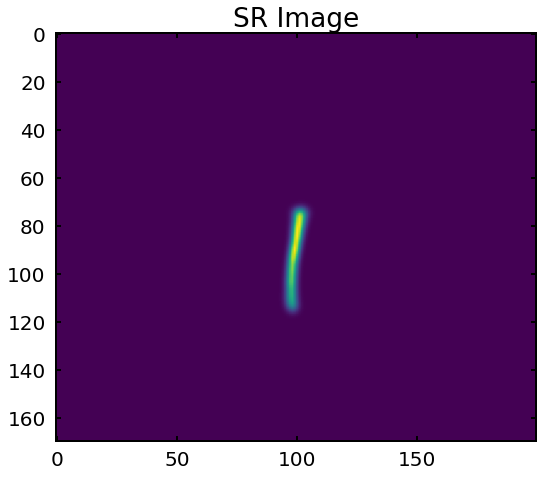

In [ ]:
import matplotlib
import matplotlib.pyplot as pyplot
import storm_analysis.sa_utilities.hdf5_to_image as h5_image

#     Create a grayscale image from a HDF5 format localizations file. This will use
#    the tracks if available, otherwise it will use the localizations.


"""
    Create a grayscale image from a HDF5 format localizations file. This will use
    the tracks if available, otherwise it will use the localizations.

    h5_name - The name of the HDF5 file.
    category - Filter for localizations of this category. The default is all categories.
    offsets - List containing [X,Y] offset of the image origin.  The default is no offset.
    scale - The 'zoom' level of the output image, i.e. if the original STORM movie was
            256x256 and scale = 2 then the output image will be 512x512.
    sigma - The sigma to use when rendering gaussians (pixels). If this is None then
            the image will be a histogram.
"""

sr_im = h5_image.render2DImage("test_measure.hdf5", scale = 5, sigma = 1.5) # # This sigma is not same value with above sigma. It has other meaning.

fig = pyplot.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
ax.imshow(sr_im)
ax.set_title("SR Image")

pyplot.show()

### ③ Applying CutOff and Analyze again. & Save New_Z txt file.


Change the tolerance for the distance from the calibration curve and redo the Z fit.

In [ ]:
import shutil
import storm_analysis.sa_utilities.fitz_c as fitz_c
import storm_analysis.sa_utilities.std_analysis as std_ana

cutoff_params = params.ParametersDAO().initFromFile("test_measure.xml")

[wx_params, wy_params] = cutoff_params.getWidthParams()
[min_z, max_z] = cutoff_params.getZRange()

# Make a copy of the .hdf5 file as this operation will change it in place.
shutil.copyfile("test_measure.hdf5", "test_measure_copy.hdf5")

# If you want to change Cutoff coefficient, use this code line.
  # cutoff_params.changeAttr("cutoff", 0.1) 

print("Previous cutoff coeff is", cutoff_params.getAttr("cutoff"))
cutoff_params.changeAttr("cutoff", 10.0)
print("Curent cutoff coeff is", cutoff_params.getAttr("cutoff"))

# Re-fit z parameters.
fitz_c.fitz("test_measure_copy.hdf5", cutoff_params.getAttr("cutoff"),
            wx_params, wy_params, min_z, max_z, cutoff_params.getAttr("z_step"))

# Mark out of range peaks as category 9. The range is specified by the min_z and max_z parameters.
std_ana.zCheck("test_measure_copy.hdf5", cutoff_params)

In [ ]:
import storm_analysis.sa_library.sa_h5py as saH5Py
import numpy

locs = saH5Py.loadLocalizations("test_measure_copy.hdf5")

mask = (locs["category"] != 9) # Mark out of z range localizations and tracks as category 9.
wx_good = 2.0*locs["xsigma"][mask]
wy_good = 2.0*locs["ysigma"][mask]

mask = (locs["category"] == 9) # Mark out of z range localizations and tracks as category 9.
wx_bad = 2.0*locs["xsigma"][mask]
wy_bad = 2.0*locs["ysigma"][mask]

print("\n")
print("Total Localization : ", len(locs["z"]))
print("Total length wx_good : ", len(wx_good))
print("Total length wy_good : ", len(wy_good))
print("\n")

# Load Z calibration parameters.
m_params = params.ParametersDAO().initFromFile("test_measure.xml")

[wx_params, wy_params] = m_params.getWidthParams()
[min_z, max_z] = m_params.getZRange()

# Z range is in microns, want nanometers.
min_z = min_z * 1.0e+3
max_z = max_z * 1.0e+3

# Calculate fit z curve at high resolution

fz_wx_1 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size
fz_wy_1 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 10))/pixel_size

# Calculate fit z curve at 100nm resolution.

fz_wx_2 = z_cal.zcalib4(wx_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size
fz_wy_2 = z_cal.zcalib4(wy_params, numpy.arange(min_z, max_z + 1, 100))/pixel_size

# Make figure.
fig = pyplot.figure(figsize = (8,8))
pyplot.scatter(wx_good, wy_good, marker = ".")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.title("Validation Result including category = 9".format(wx_good.size/mask.size))
pyplot.show()

# classified by categories ( Blue -> category != 9, Red -> category = 9)
pyplot.figure(figsize = (8,8))
pyplot.scatter(wx_good, wy_good, s = 1, color = "blue")
pyplot.scatter(wx_bad, wy_bad, s = 1, color = "red")
pyplot.scatter(fz_wx_2, fz_wy_2, marker = "o", s = 120, edgecolor = "black", facecolor = 'none', linewidths = 2)
pyplot.plot(fz_wx_1, fz_wy_1, color = "black", linewidth = 2)
pyplot.xlim(2,10)
pyplot.ylim(2,10)
pyplot.title("Good fraction : {0:.3f}".format(wx_good.size/mask.size))
pyplot.xlabel("Wx (pixels)")
pyplot.ylabel("Wy (pixels)")
pyplot.show()